# 📌 Introduction

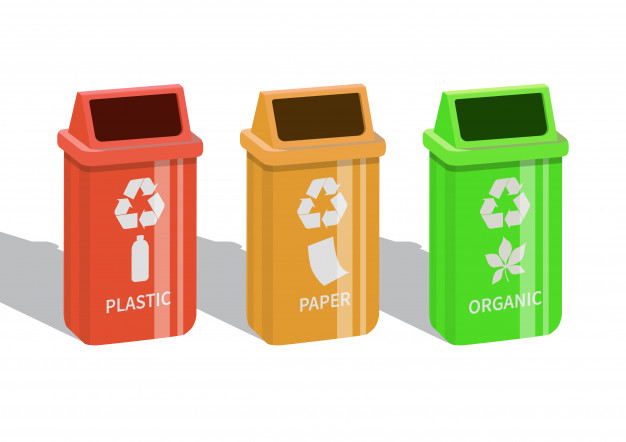

Waste is a significant global issue. Increasing volumes of waste are being generated as the global population and living standards rise. People are increasingly concerned about the production of waste and its effect, and are seeking ways to deal with the problem.

Recycling is the process of converting waste materials into new materials and objects. The recovery of energy from waste materials is often included in this concept. The recyclability of a material depends on its ability to reacquire the properties it had in its original state. It is an alternative to "conventional" waste disposal that can save material and help lower greenhouse gas emissions. Recycling can prevent the waste of potentially useful materials and reduce the consumption of fresh raw materials, thereby reducing: energy usage, air pollution (from incineration), and water pollution (from landfilling).

 **🟢 In this notebook, we will classify waste as organic or recyclable using Convolutional Neural Network (CNN).**

In [168]:
# %pip install opencv-python

In [169]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2

import warnings
warnings.filterwarnings('ignore')
import os
for dirname, _, _ in os.walk('DATASET'):
        print(dirname)

DATASET
DATASET/TEST
DATASET/TEST/R
DATASET/TEST/O
DATASET/DATASET
DATASET/DATASET/TEST
DATASET/DATASET/TEST/R
DATASET/DATASET/TEST/O
DATASET/DATASET/TRAIN
DATASET/DATASET/TRAIN/R
DATASET/DATASET/TRAIN/O
DATASET/TRAIN
DATASET/TRAIN/R
DATASET/TRAIN/O


In [170]:
train_path = "DATASET/TRAIN"
test_path = "DATASET/TEST"

## Import Libraries

In [171]:
from keras.models import Sequential 
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.utils import plot_model
from glob import glob

## Visualization

In [172]:
import os

# Loads images into array x_data; loads images' corresponding labels into array y_data.
x_data = []
y_data = []

# Filter images according to these extensions
valid_image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.gif']

for category in glob(train_path + '/*'):
    for file in tqdm(glob(category + '/*')):
        # Check if the file has a valid image extension
        if any(file.lower().endswith(ext) for ext in valid_image_extensions):
            img_array = cv2.imread(file)
            img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
            x_data.append(img_array)
            y_data.append(category.split("/")[-1])

data = pd.DataFrame({'image': x_data, 'label': y_data})

  0%|          | 0/9999 [00:00<?, ?it/s]

100%|██████████| 12565/12565 [00:04<00:00, 2604.75it/s]


In [173]:
# Total images, Total classes

data.shape

(22564, 2)

In [174]:
# Class count

from collections import Counter
Counter(y_data)

Counter({'O': 12565, 'R': 9999})

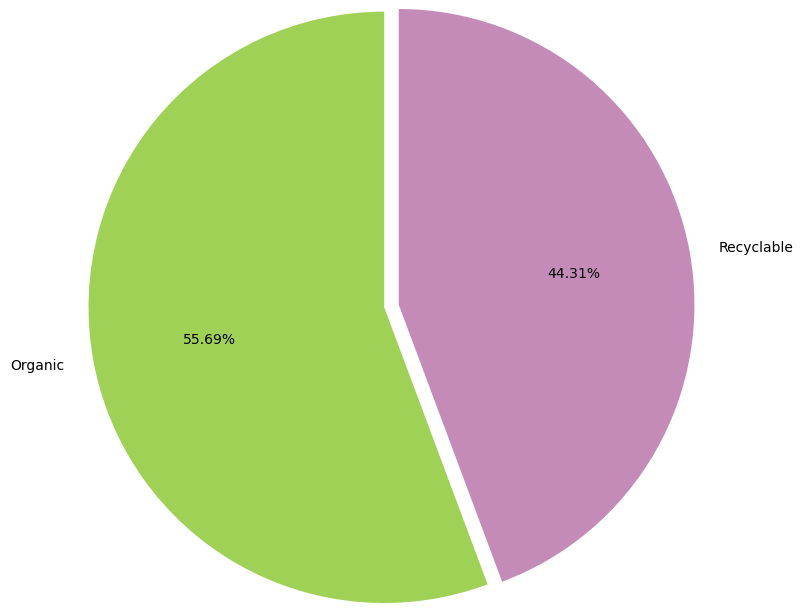

In [196]:
colors = ['#a0d157','#c48bb8']

plt.pie(data.label.value_counts(),startangle=90,explode=[0.05,0.05],autopct='%0.2f%%',
        labels=['Organic', 'Recyclable'], colors= colors,radius=2)
plt.show()

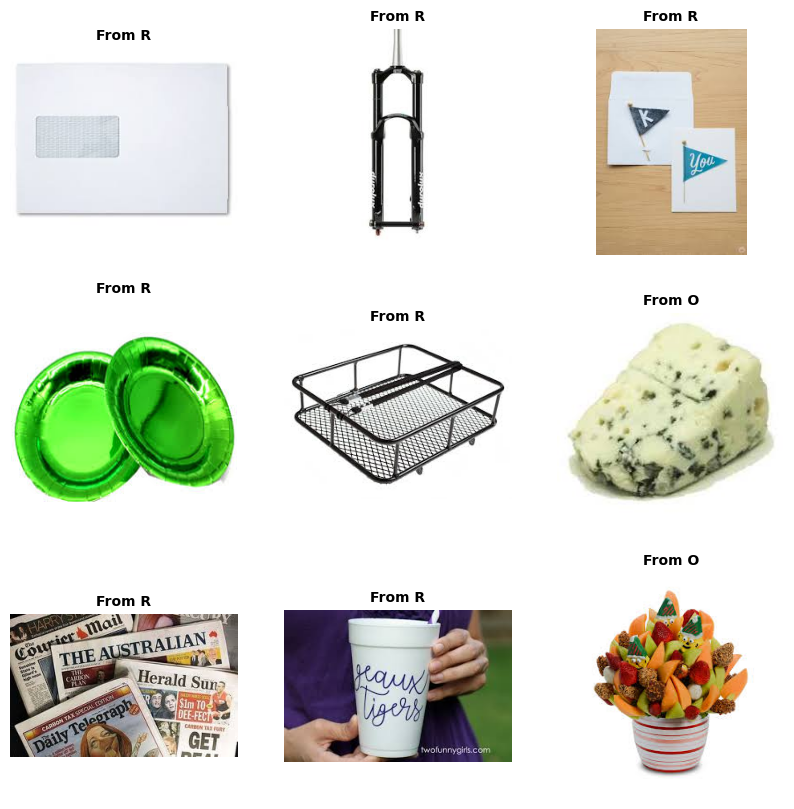

In [197]:
plt.figure(figsize=(10, 10))

for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    index = np.random.randint(15000)
    plt.imshow(data.image[index])
    plt.title('From {0}'.format(data.label[index]),fontdict={'size':10,'weight':'bold'})
    plt.axis("off")
    
plt.show()

In [198]:
className = glob(train_path + '/*' )
numberOfClass = len(className)
print("Number Of Class(es): ",numberOfClass)

Number Of Class(es):  2


! Add data preprocessing

# Convolutional Neural Network - CNN

In [199]:
img_size = (32, 32)
batch_size = 256

In [200]:
# Note. input_shape == img_size

model = Sequential()

model.add(Conv2D(32,(3,3),input_shape = (32,32,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D())

model.add(Conv2D(64,(3,3)))  
model.add(Activation("relu"))
model.add(MaxPooling2D())

model.add(Conv2D(128,(3,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dense(256))
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(Dense(64))
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(Dense(numberOfClass)) # output
model.add(Activation("sigmoid"))

# Note. Optimizer: Adam w/ default learning rate (0.001)
model.compile(loss = "binary_crossentropy",
              optimizer = "adam",
              metrics = ["accuracy"])

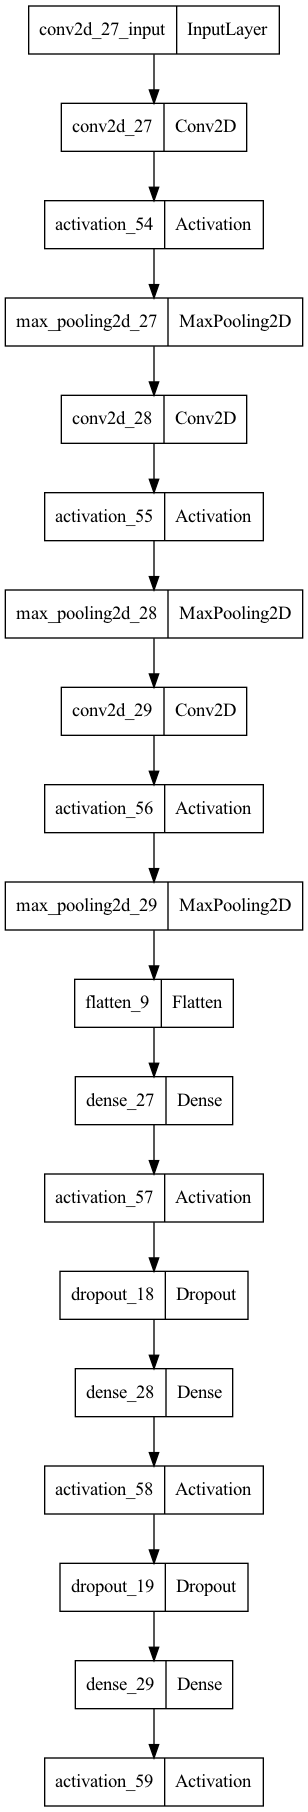

In [201]:
plot_model(model)

In [202]:
train_datagen = ImageDataGenerator(rescale= 1./255)

In [203]:
test_datagen = ImageDataGenerator(rescale= 1./255)

In [204]:
train_generator = train_datagen.flow_from_directory(
        train_path, 
        target_size = img_size,
        batch_size = batch_size,
        color_mode = "rgb",
        class_mode = "categorical")

test_generator = test_datagen.flow_from_directory(
        test_path, 
        target_size = img_size,
        batch_size = batch_size,
        color_mode = "rgb",
        class_mode = "categorical")

Found 22564 images belonging to 2 classes.
Found 2513 images belonging to 2 classes.


In [205]:
hist = model.fit_generator(
        generator = train_generator,
        epochs = 10,
        validation_data = test_generator)

Epoch 1/10
89/89 [==============================] - 12s 133ms/step - loss: 0.4877 - accuracy: 0.7840 - val_loss: 0.3301 - val_accuracy: 0.8782
Epoch 2/10
89/89 [==============================] - 12s 132ms/step - loss: 0.4226 - accuracy: 0.8209 - val_loss: 0.3274 - val_accuracy: 0.8743
Epoch 3/10
89/89 [==============================] - 12s 135ms/step - loss: 0.4034 - accuracy: 0.8288 - val_loss: 0.2795 - val_accuracy: 0.8961
Epoch 4/10
89/89 [==============================] - 12s 133ms/step - loss: 0.3860 - accuracy: 0.8405 - val_loss: 0.2739 - val_accuracy: 0.8914
Epoch 5/10
89/89 [==============================] - 12s 134ms/step - loss: 0.3712 - accuracy: 0.8441 - val_loss: 0.3042 - val_accuracy: 0.8750
Epoch 6/10
89/89 [==============================] - 12s 130ms/step - loss: 0.3595 - accuracy: 0.8499 - val_loss: 0.2730 - val_accuracy: 0.8862
Epoch 7/10
89/89 [==============================] - 11s 125ms/step - loss: 0.3499 - accuracy: 0.8564 - val_loss: 0.2756 - val_accuracy: 0.8918

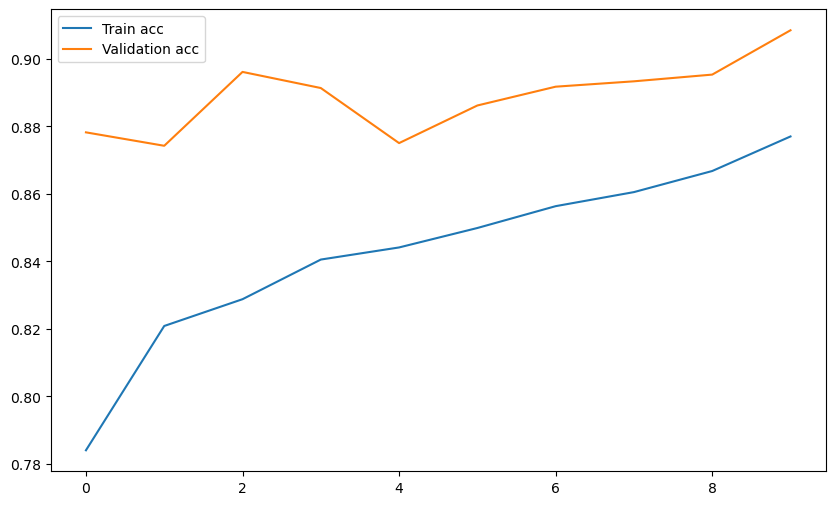

In [206]:
plt.figure(figsize = [10,6])
plt.plot(hist.history["accuracy"], label = "Train acc")
plt.plot(hist.history["val_accuracy"], label = "Validation acc")
plt.legend()
plt.show()

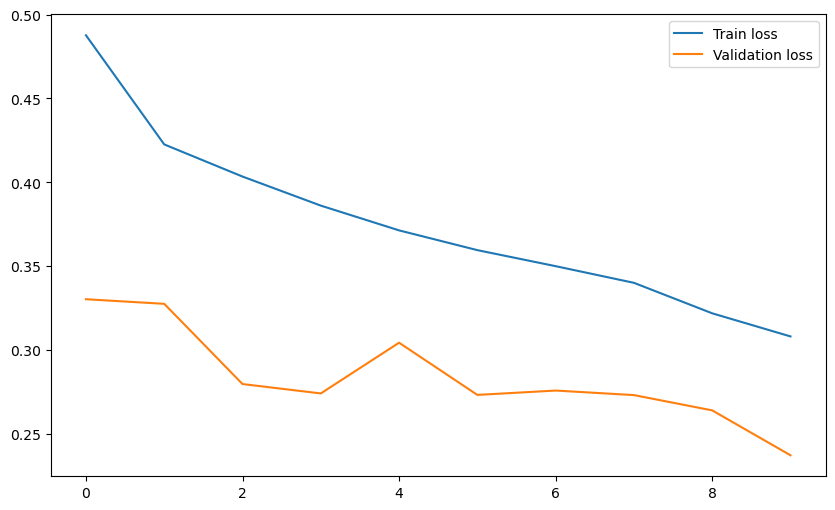

In [207]:
plt.figure(figsize = (10,6))
plt.plot(hist.history['loss'], label = "Train loss")
plt.plot(hist.history['val_loss'], label = "Validation loss")
plt.legend()
plt.show()

## Model Prediction

In [208]:
# Note. Adjust to preset image size
    # img = cv2.resize(img, img_size)
    # img = np.reshape(img, [-1, 32, 32,3])

def predict_func(img): 
    plt.figure(figsize = (6,4))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.tight_layout()
    img = cv2.resize(img, img_size)
    img = np.reshape(img, [-1, 32, 32,3])
    result = np.argmax(model.predict(img))
    
    if result == 0: print("\033[94m" + "This image -> Recyclable" + "\033[0m")
    elif result == 1: print("\033[94m" + "This image -> Organic" + "\033[0m")

1/1 [==============================] - 0s 35ms/step
This image -> Organic


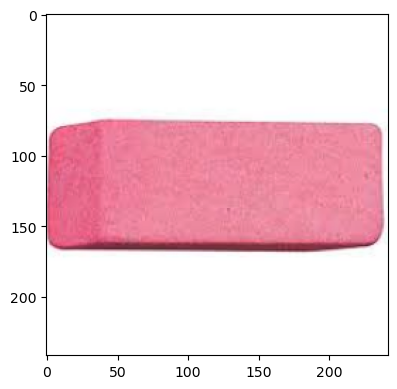

In [209]:
# test_img = cv2.imread("DATASET/TEST/O/O_12573.jpg")
test_img = cv2.imread("./test_prediction/eraser.png")
predict_func(test_img)

1/1 [==============================] - 0s 10ms/step
This image -> Organic


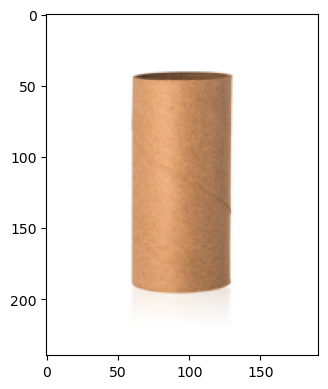

In [210]:
# test_img2 = cv2.imread("DATASET/TEST/R/R_10753.jpg")
test_img2 = cv2.imread("./test_prediction/tissue-roll.png")
predict_func(test_img2)

1/1 [==============================] - 0s 9ms/step
This image -> Organic


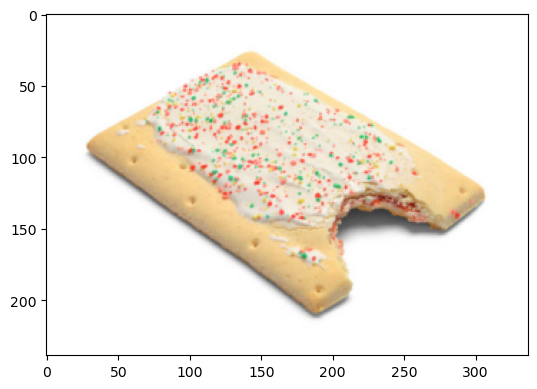

In [211]:
# test_img3 = cv2.imread("DATASET/TEST/R/R_10168.jpg")
test_img3 = cv2.imread("./test_prediction/poptart.png")
predict_func(test_img3)

1/1 [==============================] - 0s 15ms/step
This image -> Organic


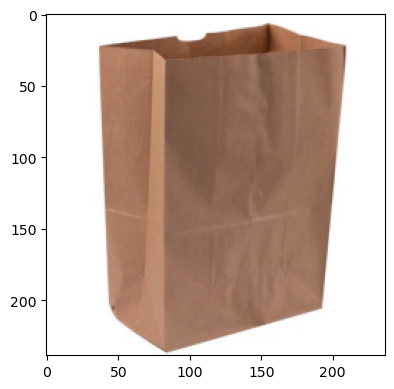

In [212]:
# test_img4 = cv2.imread("DATASET/TEST/R/R_10762.jpg")
test_img4 = cv2.imread("./test_prediction/paper-bag.png")
predict_func(test_img4)

1/1 [==============================] - 0s 8ms/step
This image -> Organic


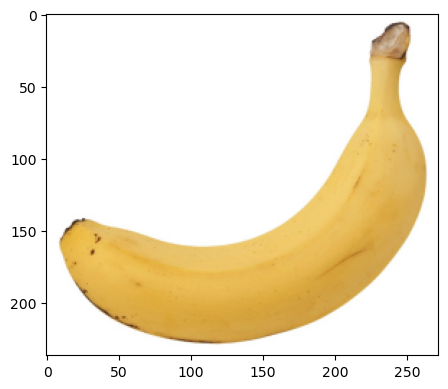

In [213]:
# test_img5 = cv2.imread("DATASET/TEST/O/O_13487.jpg")
test_img5 = cv2.imread("./test_prediction/banana.png")
predict_func(test_img5)